# 基于ROLO模型计算地球端任意观测条件月球辐照度

Chunguang Lyu (lvchunguang@lyu.edu.cn) has developed this Python code, based on an IDL program "[Estimate Moon brightness with ROLO model](https://github.com/TKouyama/ROLO_LunarCalibration)" originally coded by Toru Kouyama (t.kouyama@aist.go.jp).

Feb 15, 2025

## 1.1 准备工作

### 1.1.1 导入Python模块

In [29]:
import spiceypy as spice
import numpy as np
import csv
from datetime import datetime
import math
import os
import pandas as pd
from scipy.interpolate import interp1d
import pprint
import matplotlib.pyplot as plt

### 1.1.2 配置SPICE参数文件

In [30]:
# SPICE内核文件路径 
kernel_paths = [
    'kernels/lsk/naif0012.tls',
    'kernels/spk/planets/de430.bsp',
    'kernels/fk/planets/earth_assoc_itrf93.tf',
    'kernels/fk/planets/RSSD0002.TF',
    'kernels/fk/satellites/moon_080317.tf',
    'kernels/pck/moon_pa_de421_1900-2050.bpc',
    'kernels/pck/earth_720101_070426.bpc',
    'kernels/pck/earth_000101_160620_160330.bpc',
    'kernels/pck/earth_070425_370426_predict.bpc',
    'kernels/pck/pck00010.tpc'
]

# 初始化SPICE内核（必须在使用前加载）
def load_spice_kernels(kernel_paths):
    for kernel in kernel_paths:
        spice.furnsh(kernel)

# 预先生成某卫星的SPK文件，用于计算观测几何
load_spice_kernels(kernel_paths)

### 1.1.3 Python模块和数据文件说明

- Python模块
    - 该程序的核心模块为**spiceypy**。它是NASA 导航与辅助信息设施（NAIF）开发的 SPICE（Spacecraft Planet Instrument C-matrix Events）系统的Python接口，用于处理太空任务中的几何观测数据，如行星轨道计算、时间转换、坐标系变换等。该模块基于NAIF的C语言SPICE工具包（如N0066版本）的Python封装，通过ctypes实现底层调用。核心功能包括：  
        - **时间尺度转换**  
        支持协调世界时（UTC）、历书时（ET）、航天器时钟时间（SCLK）之间的转换，需依赖 闰秒内核（LSK） 和 航天器时钟内核（SCLK）。 
        - **空间几何计算**  
        依赖行星星历（SPK）和参考框架内核（FK），计算航天器与行星的轨道位置、光照角度、坐标变换（如地心坐标系到探测器坐标系）。
        - **内核文件管理**  
        SPICE 内核包含多种数据文件（如 SPK、PCK、CK、LSK 等），需通过furnsh() 加载，支持元内核（MK）批量加载。
        - **事件探测**  
        支持计算特定几何事件（如探测器进入行星阴影）的发生时间，这需结合多类内核数据。
    
    - 应用场景
        - **行星科学任务**  
        分析卡西尼号轨道数据、火星探测器定位等。
        - **任务规划与仿真**  
        计算航天器与行星的可见时间窗口、光照条件。
        - **数据可视化**  
        结合 Matplotlib 或 WebGeocalc 工具生成轨道图或几何关系图。
    
    - 开发与维护
        - 开源与社区支持：spiceypy 是第三方维护的开源项目，但被 NAIF 官方推荐用于 Python 教学与科研3。
        - 兼容性：支持 Python 3.6+，依赖 CSPICE 动态库（自动包含在安装包中）3。

    - 示例项目——卡西尼号轨道可视化
        - 通过加载土星（ID 699）和卡西尼号（ID -82）的 SPK 内核，计算其相对位置并绘图（代码参考 [SpiceyPy 官方示例](https://naif.jpl.nasa.gov/pub/naif/)）



- 数据文件
    - 'naif0012.tls.pc'      
    **闰秒内核（LSK, Leapseconds Kernel）**  
    提供 UTC（协调世界时）与 ET（历书时）之间的闰秒转换规则，用于精确时间尺度转换。  
    例如，naif0012.tls 是 NASA 官方发布的常用闰秒内核文件。

    - 'de430.bsp'  
    **行星星历内核（SPK, Spacecraft and Planet Ephemeris Kernel）**  
    存储行星、月球等天体的位置和速度数据。  
    de430.bsp 是 JPL 发布的高精度行星历表，覆盖时间范围通常为 1550–2650 年，适用于高精度轨道计算。  

    - 'earth_assoc_itrf93.tf'和'RSSD0002.TF'  
    **参考框架内核（FK, Frame Kernel）**  
    定义天体的参考坐标系。  
    例如：earth_assoc_itrf93.tf：定义地球与国际地球参考框架（ITRF93）的关联。  
    RSSD0002.TF：可能与特定任务或机构的坐标系定义相关（如深空探测任务）。  

    - 'moon_080317.tf'  
    **参考框架内核（FK, Frame Kernel）**  
    定义月球的坐标系，例如月面固定坐标系或惯性坐标系，用于定位月球表面或轨道器位置。  

    - 'moon_pa_de421_1900-2050.bpc'  
    **类型：行星常数内核（PCK, Planetary Constants Kernel）**  
    存储月球的物理参数，如自转轴方向、极移模型（PA, Polar Axis）等。  
    de421 表示基于 JPL DE421 历表的参数。  

    - 'earth_720101_070426.bpc'、earth_000101_160620_160330.bpc和'earth_070425_370426_predict.bpc'  
    以earth_开头的文件表示**地球物理参数内核**  
    定义地球的极移、章动等参数。  
    例如：earth_720101_070426.bpc覆盖 1972–2007 年地球极移数据。  
    earth_000101_160620_160330.bpc可能是更新的极移预测或修正数据。  

    - 'pck00010.tpc'  
    **通用行星常数内核**  
    存储天体（如行星、卫星）的半径、质量、引力常数等基础物理参数。  

这些内核文件共同支持天体位置计算（如地月距离、相位角）、坐标系转换（如地球到月球的坐标映射）及时间同步，是 ROLO 模型计算月球辐射亮度的关键参数。


### 1.1.4 配置ROLO、辐射、观测文件

In [31]:
## ROLO模型参数
ROLO_params_path = "data/ROLO_params.csv"

## Apollo月球土壤和岩石数据文件路径
SOIL_path = "data/Apollo_soil/62231_data.txt"
ROCK_path = "data/Apollo_soil/67445_data.csv"

## Solar irradiance model
SOL_model_path = "data/Wehrli_1985.txt"

## 卫星TLE文件路径
ifname_tle = "data/satellites/terra.tle"
## 卫星bsp文件输出路径
ofname_spk = "kernels/spk/satellites/terra.bsp"

## 1.2 核心函数定义

### 1.2.1 卫星TLE文件-->SPK文件

In [4]:
def generate_spk_ROLO(ifname_tle,log_output=None):
    # 读取 TLE 文件
    tle_lines = []
    with open(ifname_tle, 'r') as f:
        for line in f:
            # 去除行首尾空白字符（包括换行符）
            line = line.strip()
            # 确保行以 '1' 或 '2' 开头，并且长度为 69
            if line.startswith(('1', '2')) and len(line) == 69:
                tle_lines.append(line)
    
    # 解析TLE元素
    epochs = []
    elems_list = []
    prev_epoch = -1e10
    for i in range(0, len(tle_lines)-1, 2):
        line1 = tle_lines[i]
        line2 = tle_lines[i+1]
        # 确保每行长度为 69
        if len(line1) != 69 or len(line2) != 69:
            print(f"Skipping invalid TLE lines {i}-{i+1}: incorrect length")
            continue
        
        # 解析 TLE
        try:
            lineln = len(line1)+len(line2)
            epoch, elems = spice.getelm(1999, lineln, [line1, line2])
        except Exception as e:
            print(f"Error parsing TLE lines {i}-{i+1}: {e}")
            continue
        
        # 检查 epoch 顺序
        if epoch > prev_epoch:
            epochs.append(epoch)
            elems_list.extend(elems)
            prev_epoch = epoch
    # 转换为numpy数组
    num_epochs = len(epochs)
    epochs_arr = np.array(epochs, dtype=np.float64)
    elems_arr = np.array(elems_list, dtype=np.float64).reshape(num_epochs, 10)
    print(epochs_arr)
    print(elems_arr)

    # 设置时间范围（扩展前后7天和365天）
    spd = spice.spd()  # 一天的秒数
    first = epochs_arr[0] - 7 * spd
    last = epochs_arr[-1] + 365 * spd
    
    # 打印时间范围信息
    tle_first_utc = spice.et2utc(epochs_arr[0], 'ISOC', 0)
    tle_last_utc = spice.et2utc(epochs_arr[-1], 'ISOC', 0)
    pass_first_utc = spice.et2utc(first, 'ISOC', 0)
    pass_last_utc = spice.et2utc(last, 'ISOC', 0)
    
    print("TLE coverage epoch:")
    print(f" {tle_first_utc}")
    print(f" {tle_last_utc}")
    print("Pass coverage epoch:")
    print(f" {pass_first_utc}")
    print(f" {pass_last_utc}")
    if log_output is not None:
        # 这里可以添加日志记录逻辑
        pass
    
    # 创建SPK文件
    if os.path.exists(ofname_spk):
        os.remove(ofname_spk)   
    handle = spice.spkopn(ofname_spk, 'TEST_FILE', 1000)
    # 定义常数数组（与IDL代码保持一致）
    consts = np.array([
        1.082616e-3,
        -2.53881e-6,
        -1.65597e-6,
        7.43669161e-2,
        120.0,
        78.0,
        6378.135,
        1.0
    ], dtype=np.float64)
    # 写入SPK type 10 segment
    spice.spkw10(
        handle,           # handle
        -999,             # 对象ID（自定义）
        399,              # 中心天体（地球）
        'J2000',          # 参考系
        first,            # 起始时间
        last,             # 结束时间
        'TEST',           # 段名称
        consts,           # 常数数组
        num_epochs,       # 元素数量
        elems_arr.ravel(),# 展平的元素数组
        epochs_arr        # 历元数组
    )
    
    # 关闭SPK文件并清理内核
    spice.spkcls(handle)
    spice.kclear()
    
    return 0


### 1.2.2 读取ROLO系数文件

In [5]:
def read_rolo_params(filename):
    """
    读取 ROLO 参数文件并返回参数字典以及额外的固定参数。
    
    参数：
    filename (str): ROLO 参数文件路径
    
    返回：
    rolo_params (dict): ROLO 参数字典，键为波长，值为参数字典
    coeff_c (numpy.ndarray): 形状为 (4,) 的固定数组
    coeff_p (numpy.ndarray): 形状为 (4,) 的固定数组
    """
    # 固定的 coeff_c 和 coeff_p 参数
    #==============================
    # Coefficients for all bands
    #==============================
    #元論文でのc1 は c2に、c2はc1に、c3はc4に、c4はc3になるのがよい, based on Yokota and Stone's discussion
    coeff_c = np.array([-0.00134252, 0.000341152, 0.000662286, 0.000959062], dtype=np.float64)
    coeff_p = np.array([4.06054, 12.8802, -30.5858, 16.7498], dtype=np.float64)
    
    rolo_params = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # 跳过表头
        for row in reader:
            if not row:
                continue  # 跳过空行
            wavelength = float(row[0])
            a0 = float(row[1])
            a1 = float(row[2])
            a2 = float(row[3])
            a3 = float(row[4])
            b1 = float(row[5])
            b2 = float(row[6])
            b3 = float(row[7])
            d1 = float(row[8])
            d2 = float(row[9])
            d3 = float(row[10])
            rolo_params[wavelength] = {
                'a0': a0,
                'a1': a1,
                'a2': a2,
                'a3': a3,
                'b1': b1,
                'b2': b2,
                'b3': b3,
                'd1': d1,
                'd2': d2,
                'd3': d3
            }
    
    return rolo_params, coeff_c, coeff_p

### 1.2.3 对ROLO系数再处理

In [6]:
def get_params_rolo(sel_wav, rolo_params):
    """
    根据给定波长获取对应的 ROLO 参数。

    参数：
    sel_wav (float): 目标波长
    rolo_params (dict): ROLO 参数字典

    返回：
    param_a (numpy.ndarray): 形状为 (4,) 的 a 参数数组
    param_b (numpy.ndarray): 形状为 (3,) 的 b 参数数组
    param_d (numpy.ndarray): 形状为 (3,) 的 d 参数数组
    """
    # 获取所有波长
    wavelengths = np.array(list(rolo_params.keys()))
    # 计算绝对差异并找到最近的波长
    closest_index = np.argmin(np.abs(wavelengths - sel_wav))
    closest_wav = wavelengths[closest_index]
    
    # 获取对应参数
    params = rolo_params[closest_wav]
    param_a = np.array([params['a0'], params['a1'], params['a2'], params['a3']], dtype=np.float64)
    param_b = np.array([params['b1'], params['b2'], params['b3']], dtype=np.float64)
    param_d = np.array([params['d1'], params['d2'], params['d3']], dtype=np.float64)
    
    return param_a, param_b, param_d

### 1.2.4 计算月表反射率

In [7]:
def calculate_rolo_reflectance(param_a, param_b, param_d, coeff_c, coeff_p, 
                               phase_angle_deg, sub_solar_lon, 
                               sub_obs_lat_deg, sub_obs_lon_deg):
    """
    根据 ROLO 参数计算反射率。

    参数：
    param_a (numpy.ndarray): 形状为 (4,) 的 a 参数数组
    param_b (numpy.ndarray): 形状为 (3,) 的 b 参数数组
    param_d (numpy.ndarray): 形状为 (3,) 的 d 参数数组
    coeff_c (numpy.ndarray): 形状为 (4,) 的 c 参数数组
    coeff_p (numpy.ndarray): 形状为 (4,) 的 p 参数数组
    phase_angle_deg (float): 相位角（度）
    sub_solar_lon (float): 太阳子点经度
    sub_obs_lat_deg (float): 观测子点纬度
    sub_obs_lon_deg (float): 观测子点经度

    返回：
    result (float): 反射率
    """
    term_A = np.zeros(9, dtype=np.float64)
    
    # term_A[0]
    for i in range(4):
        term_A[0] += param_a[i] * (phase_angle_deg * np.pi / 180.0) ** i
    
    # term_A[1]
    for j in range(1, 4):
        term_A[1] += param_b[j-1] * (sub_solar_lon) ** (2*j -1)
    
    # term_A[2-5]
    term_A[2] = coeff_c[0] * sub_obs_lat_deg
    term_A[3] = coeff_c[1] * sub_obs_lon_deg
    term_A[4] = coeff_c[2] * sub_solar_lon * sub_obs_lat_deg
    term_A[5] = coeff_c[3] * sub_solar_lon * sub_obs_lon_deg
    
    # term_A[6-8]
    phase_rad = phase_angle_deg * np.pi / 180.0
    term_A[6] = param_d[0] * np.exp(-phase_angle_deg / coeff_p[0])
    term_A[7] = param_d[1] * np.exp(-phase_angle_deg / coeff_p[1])
    term_A[8] += param_d[2] * np.cos((phase_angle_deg - coeff_p[2]) / coeff_p[3])
    
    result = np.exp(np.sum(term_A))
    return result

### 1.2.5 读取太阳辐照度文件

In [8]:
# 读取Wehrli_1985.txt中的太阳辐照度数据
def read_wehrli_data(filename):
    data = []
    with open(filename, 'r') as f:
        next(f)  # 跳过表头
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 2:
                wavelength = float(parts[0])
                radiance = float(parts[1])
                data.append((wavelength, radiance))
    return data

### 1.2.6 线性插值太阳辐照度

In [9]:
# 线性插值太阳辐照度
def interpol_solar_radiance(rolo_wavelengths, wehrli_data, method='linear'):
    """
    对 ROLO 参数中的波长进行插值，获取对应的太阳辐照度。

    参数：
        rolo_wavelengths: 波长。
        wehrli_data (list): 太阳辐照度数据列表，每个元素为 (波长, 辐照度)。
        method (str): 插值方法，可选 'linear', 'quadratic', 'cubic'，默认为 'linear'。

    返回：
        dict: 插值后的太阳辐照度字典，键为波长，值为插值的辐照度。
    """
    # 提取太阳辐照度的波长和辐照度
    wavelengths_radiance = np.array([d[0] for d in wehrli_data])
    radiances = np.array([d[1] for d in wehrli_data])

    # 清理数据：排除 NaN 值
    valid_indices = ~np.isnan(wavelengths_radiance) & ~np.isnan(radiances)
    wavelengths_clean = wavelengths_radiance[valid_indices]
    radiances_clean = radiances[valid_indices]

    # 如果没有有效数据，返回空结果
    if len(wavelengths_clean) == 0 or len(radiances_clean) == 0:
        return {}

    # 创建插值函数
    f = interp1d(wavelengths_clean, radiances_clean, kind=method, fill_value='extrapolate')

    # 对 ROLO 波长进行插值
    interpolated_radiances = f(rolo_wavelengths)

    # 将结果整理为字典
    interpolated_dict = {wl: rad for wl, rad in zip(rolo_wavelengths, interpolated_radiances)}

    return interpolated_dict

### 1.2.7 计算指定时间的观测者几何信息

In [10]:
def get_geometry_with_spice_rolo_location(obs_date, obs_sat_name, target_body_name, target_frame_name,
                                          obs_lat_earth=None, obs_lon_earth=None, obs_alt_earth=None):
    """
    获取指定观测时间的观测者几何信息。
    支持地球上任意地点（纬度、经度、高度）的观测者位置。
    """
    # 检查输入参数
    if not obs_date:
        raise ValueError("Date is not defined.")

    # 将UTC时间转换为ET（历书时）
    et = spice.str2et(obs_date)

    # 获取目标天体的半径
    radii = spice.bodvrd(target_body_name, 'RADII', 3)[1]

    # 计算月球在ITRF93坐标系中的位置（带光行时和路径修正）
    lunar_pos, ltime_LT = spice.spkpos(target_body_name, et, 'ITRF93', 'LT+S', obs_sat_name)
    tmp_L_distance = np.linalg.norm(lunar_pos)

    # 计算太阳在月球坐标系中的位置（带光行时和路径修正）
    sun_pos_lunar, ltime_SL = spice.spkpos('Sun', et - ltime_LT, target_frame_name, 'LT+S', target_body_name)
    SL_distance = np.linalg.norm(sun_pos_lunar)
    AU = 149597870.700  # 1 AU in km
    SL_distance_au = SL_distance / AU

    # 计算太阳在月球上的直射点
    subpoint_solar, subepc, subsrfvec_solar = spice.subslr("Intercept: ellipsoid", target_body_name, et,
                                                          target_frame_name, "LT+S", "Earth")
    _, sub_solar_lon, sub_solar_lat = spice.reclat(subpoint_solar)

    if obs_lon_earth is None:
        # 如果未提供观测者位置，则使用卫星位置
        terra_pos, _ = spice.spkpos(obs_sat_name, et, 'ITRF93', 'NONE', 'EARTH')
        _, sub_terra_lon_e, sub_terra_lat_e = spice.reclat(terra_pos)

        # 计算月球到卫星的距离
        terra_pos_lunar, _ = spice.spkpos(target_body_name, et - ltime_LT, target_frame_name, 'LT+S', obs_sat_name)
        LT_distance = np.linalg.norm(terra_pos_lunar)

        # 计算卫星在月球上的直射点
        subpoint_terra, subepc, subsrfvec_terra = spice.subpnt("Intercept: ellipsoid", target_body_name, et,
                                                              target_frame_name, "LT+S", obs_sat_name)
        _, sub_terra_lon, sub_terra_lat = spice.reclat(subpoint_terra)
    else:
        # 如果提供了观测者位置，则使用固定位置
        body = 'EARTH'
        radii_earth = spice.bodvrd(body, 'RADII', 3)[1]
        re = radii_earth[0]
        rp = radii_earth[2]
        flat = (re - rp) / re

        # 将观测者位置从地理坐标转换为笛卡尔坐标
        obs_pos = spice.pgrrec(body, obs_lon_earth, obs_lat_earth, obs_alt_earth, re, flat)

        # 计算观测者到月球的状态向量
        state, ltime = spice.spkcpo(target_body_name, et, target_frame_name, 'OBSERVER', 'CN+S',
                                    obs_pos, 'EARTH', 'ITRF93')
        sub_obs_moon_vec = -state[:3]
        LT_distance = np.linalg.norm(sub_obs_moon_vec)

        # 计算观测者在月球上的直射点
        _, sub_terra_lon, sub_terra_lat = spice.reclat(sub_obs_moon_vec)
        subpoint_terra = sub_obs_moon_vec

    # 计算地球在月球上的直射点
    subpoint_earth, subepc, subsrfvec_earth = spice.subpnt("Intercept: ellipsoid", target_body_name, et,
                                                           target_frame_name, "LT+S", "Earth")
    _, sub_earth_lon, sub_earth_lat = spice.reclat(subpoint_earth)

    # 计算月球到地球的距离
    earth_pos_lunar, _ = spice.spkpos(target_body_name, et - ltime_LT, target_frame_name, 'LT+S', "Earth")
    LE_distance = np.linalg.norm(earth_pos_lunar)

    # 单位向量化
    u_subpoint_solar = subpoint_solar / np.linalg.norm(subpoint_solar)
    u_subpoint_earth = subpoint_earth / np.linalg.norm(subpoint_earth)
    u_subpoint_terra = subpoint_terra / np.linalg.norm(subpoint_terra)

    # 计算相位角（太阳-月球-地球）
    phase_angle_sun_moon_earth = np.arccos(np.dot(u_subpoint_earth, u_subpoint_solar)) * 180.0 / np.pi

    # 计算相位角（太阳-月球-观测者）
    phase_angle_sun_moon_observer = np.arccos(np.dot(u_subpoint_terra, u_subpoint_solar)) * 180.0 / np.pi

    # Scan観測を再現するために後々必要
    phi_deg = 00./3600. #視線中心からのズレ量
    lam_deg = 00. #画像上で視野中心-天体中心を結ぶ線とx軸のなす角
    #撮像条件と衛星姿勢から決まるものについて ;;
    #North vector :: fkが存在するならSpice からもらってくる
    NA_deg = 90. # +31.07-0.
    # 返回结果
    obs_geo = {
        'ST_distance': SL_distance,
        'TO_distance': LT_distance,
        'ssl_longitude': sub_solar_lon * 180.0 / np.pi,
        'ssl_latitude': sub_solar_lat * 180.0 / np.pi,
        'ssc_longitude': sub_terra_lon * 180.0 / np.pi,
        'ssc_latitude': sub_terra_lat * 180.0 / np.pi,
        'N_azimuth': NA_deg,  # 默认值
        'phi': phi_deg,  # 默认值
        'lam': lam_deg,  # 默认值
        'phase': phase_angle_sun_moon_observer
    }

    return obs_geo

In [ ]:
def get_phase_angle(sub_obs_lat_deg,sub_obs_lon_deg,sub_solar_lat,sub_solar_lon):
    # 位相角的计算
    # 观测方向向量
    obs_direction = [
        np.cos(np.radians(sub_obs_lat_deg)) * np.cos(np.radians(sub_obs_lon_deg)),
        np.cos(np.radians(sub_obs_lat_deg)) * np.sin(np.radians(sub_obs_lon_deg)),
        np.sin(np.radians(sub_obs_lat_deg))
    ]
    # 太阳方向向量
    sun_direction = [
        np.cos(sub_solar_lat) * np.cos(sub_solar_lon),
        np.cos(sub_solar_lat) * np.sin(sub_solar_lon),
        np.sin(sub_solar_lat)
    ]

    # 计算位相角
    # 计算点积
    dot_product = np.dot(obs_direction, sun_direction)
    # 计算弧度值（确保结果在 -1 和 1 之间）
    phase_angle_rad = np.arccos(np.clip(dot_product, -1.0, 1.0))
    # 转换为度数
    phase_angle_deg = np.degrees(phase_angle_rad)
    # 添加绝对值
    phase_angle_deg = abs(phase_angle_deg)
    # 打印结果
    # print("Phase angle (degrees):", phase_angle_deg)
    return phase_angle_deg

### 1.2.8 读取Apollo月球土壤和岩石文件

In [36]:
def read_apollo_data(soil_path, rock_path):
    """
    读取 Apollo 月球土壤和岩石数据。
    
    参数：
    soil_path (str): 月球土壤数据文件路径
    rock_path (str): 月球岩石数据文件路径
    
    返回：
    wav_soil (numpy.ndarray): 土壤波长
    spec_soil (numpy.ndarray): 土壤光谱
    wav_rock (numpy.ndarray): 岩石波长
    spec_rock (numpy.ndarray): 岩石光谱
    """
    # 月球土壤数据
    soil_data = pd.read_csv(soil_path, sep='\s+', header=None)
    wav_soil = np.array(soil_data.iloc[1:, 0], dtype=np.float64)  # 跳过标题行
    spec_soil = np.array(soil_data.iloc[1:, 1], dtype=np.float64)  # 跳过标题行
    
    # 月球岩石数据
    rock_data = pd.read_csv(rock_path, header=None)
    wav_rock = np.array(rock_data.iloc[1:, 0], dtype=np.float64)  # 跳过标题行
    spec_rock = np.array(rock_data.iloc[1:, 1], dtype=np.float64)  # 跳过标题行
    
    return wav_soil, spec_soil, wav_rock, spec_rock

### 1.2.9 基于ROLO模型生成连续光谱

In [34]:
def generate_rolo_spec(soil_path, rock_path, rolo_params_path, 
                       phase_angle_deg, sub_solar_lon, 
                       sub_obs_lat_deg, sub_obs_lon_deg, out_wav):
    """
    生成 ROLO 光谱模型。
    
    参数：
    soil_path (str): 月球土壤数据文件路径
    rock_path (str): 月球岩石数据文件路径
    rolo_params_path (str): ROLO 参数文件路径
    phase_angle_deg (float): 相位角（度）
    sub_solar_lon (float): 太阳子点经度
    sub_obs_lat_deg (float): 观测子点纬度
    sub_obs_lon_deg (float): 观测子点经度
    out_wav (numpy.ndarray): 输出波长
    
    返回：
    Disk_reflectance_rolo (numpy.ndarray): ROLO 反射率
    Apollo_reflectance (numpy.ndarray): 合并后的光谱
    """
    # 读取 Apollo 数据
    wav_soil, spec_soil, wav_rock, spec_rock = read_apollo_data(soil_path, rock_path)
    
    # 波长对齐：将岩石光谱插值到土壤波长
    interp_spec = interp1d(wav_rock * 1000, spec_rock, kind='linear', fill_value="extrapolate")
    spec_rock_rev = interp_spec(wav_soil)
    
    # 合并土壤和岩石光谱（95%土壤 + 5%岩石）
    spec_merge = 0.95 * spec_soil + 0.05 * spec_rock_rev
    
    # 有效值域限制：岩石光谱大于 0.2 的部分
    valid_indices = np.where(spec_rock_rev > 0.2)[0]
    wav_soil_valid = wav_soil[valid_indices]
    spec_soil_valid = spec_soil[valid_indices]
    spec_rock_rev_valid = spec_rock_rev[valid_indices]
    spec_merge_valid = spec_merge[valid_indices]
    
    # 读取 ROLO 参数
    rolo_params, coeff_c, coeff_p = read_rolo_params(rolo_params_path)
    sel_wav = np.array(list(rolo_params.keys()))
    # 初始化结果数组
    Disk_reflectance_rolo = np.zeros(len(sel_wav), dtype=np.float64)
    Apollo_reflectance = np.zeros(len(sel_wav), dtype=np.float64)
    
    # 处理每个波长
    for i in range(len(sel_wav)):
        param_a, param_b, param_d = get_params_rolo(sel_wav[i], rolo_params)
        
        # 计算 ROLO 反射率
        disk_reflectance = calculate_rolo_reflectance(
            param_a, param_b, param_d, coeff_c, coeff_p,
            phase_angle_deg, sub_solar_lon,
            sub_obs_lat_deg, sub_obs_lon_deg
        )
        Disk_reflectance_rolo[i] = disk_reflectance
        
        # 查找最接近的波长并获取合并后的光谱
        min_pos = np.argmin(np.abs(wav_soil_valid - sel_wav[i]))
        Apollo_reflectance[i] = spec_merge_valid[min_pos]

    # 筛选有效波长（大于301 nm）
    sel_pos = np.where(sel_wav > 301)[0]

    # 构建矩阵
    array = np.zeros((2, 2))
    array[0, 0] = np.sum(Apollo_reflectance[sel_pos] ** 2)
    array[1, 0] = np.sum(Apollo_reflectance[sel_pos] ** 2 * sel_wav[sel_pos])
    array[0, 1] = array[1, 0]
    array[1, 1] = np.sum(Apollo_reflectance[sel_pos] ** 2 * sel_wav[sel_pos] ** 2)

    # 构建向量
    vec = np.zeros(2)
    vec[0] = np.sum(Apollo_reflectance[sel_pos] * Disk_reflectance_rolo[sel_pos])
    vec[1] = np.sum(Apollo_reflectance[sel_pos] * Disk_reflectance_rolo[sel_pos] * sel_wav[sel_pos])

    # 计算逆矩阵并求解
    result = np.linalg.inv(array) @ vec

    # 输出拟合结果
    # print(f"Fitted a, b: {result[0]}, {result[1]}")

    # 计算拟合后的反射率
    tmp_fitted_reflectance_ROLO = (result[0] + result[1] * wav_soil_valid) * spec_merge_valid

    # print,"Fitted a, b: ",result[0],result[1]

    # 根据是否指定输出波长，调整结果
    if len(out_wav) == 0:
        out_wav = wav_soil_valid
        fitted_reflectance_ROLO = tmp_fitted_reflectance_ROLO
    else:
        # 使用线性插值调整到指定的波长范围
        interp_spec = interp1d(wav_soil_valid, tmp_fitted_reflectance_ROLO,kind = 'linear', fill_value="extrapolate")
        fitted_reflectance_ROLO = interp_spec(out_wav)
    
    # 输出拟合后的反射率结果
    # print("Fitted Reflectance:", fitted_reflectance_ROLO)
    
    return Disk_reflectance_rolo,fitted_reflectance_ROLO

## 1.3 模拟与验证流程

### 1.3.1 指定常量

In [14]:
# 一个天文单位
AU = 149597870700.0/1000.0 #1 AU (km)
# 月球立体角（sr）
Omega_M = 6.4177e-5

### 1.3.2 指定观测者几何

In [ ]:
# 生成卫星的SPK文件
generate_spk_ROLO(ifname_tle, ofname_spk)
# 添加卫星spk参数
spice.furnsh(ofname_spk)

### 1.3.3 指定观测时间

In [32]:
# obs_date = "2025-11-03T15:05:00"
# str_obs_date = obs_date[:4] + obs_date[5:7] + obs_date[8:10] + 'T' + obs_date[11:13] + obs_date[14:16] + obs_date[17:19]
# print(str_obs_date)  # 输出: 20251103T150500

# 读取 CSV 文件
df = pd.read_csv('data/obs_date.csv',encoding='ANSI')
# 合并日期和时间列
datetime_str = df['日期'] + ' ' + df['时间']
# 转换为 datetime 类型
datetime_obj = pd.to_datetime(datetime_str)
# 格式化为期望的字符串格式
formatted_datetime = datetime_obj.dt.strftime('%Y-%m-%dT%H:%M:%S')
# 转换为 NumPy 数组
obs_date_array = np.array(formatted_datetime)
print(obs_date_array)

['2025-11-03T15:05:00' '2025-11-03T00:05:00' '2025-11-03T03:05:00'
 '2025-11-03T06:05:00' '2025-11-03T09:05:00' '2025-11-03T12:05:00'
 '2025-11-03T18:05:00' '2025-11-03T21:05:00']


### 1.3.4 数据提取及预处理

In [17]:
# 读取ROLO模型系数
rolo_params, coeff_c, coeff_p = read_rolo_params(ROLO_params_path)
wavelengths = list(rolo_params.keys())
print(wavelengths[0])

# 读取Wehrli_1985.txt数据
wehrli_data = read_wehrli_data(SOL_model_path)
print(wehrli_data[0])

# 太阳辐照度插值
solar_radiance_rolo = interpol_solar_radiance(wavelengths, wehrli_data)
solar_radiance_rolo = np.array(list(solar_radiance_rolo.values()))/1000 # W/m2/nm
print("Interpolated Radiance:")
print(solar_radiance_rolo[0])

# 从SPK文件中提取ID
ids = spice.spkobj(ofname_spk)
# 获取第一个ID，并将ID转换为字符串
obj = ids[0]; obs_sat_name = str(obj).strip()
print(obs_sat_name)

# 定义目标体和参考框架
target_body_name = "MOON"
target_frame_name = "MOON_ME"

350.0
(199.5, 5.0)
Interpolated Radiance:
0.992
-999


### 1.3.5 计算观测者几何

In [18]:
# 将日期时间数组转换为 Pandas Series
obs_dates = pd.Series(obs_date_array)
# 使用 map 和 lambda 函数
# results = obs_dates.map(
#     lambda x: get_geometry_with_spice_rolo_location(
#         x, obs_sat_name, target_body_name, target_frame_name
#     )
# ).values
# 列表推导式
results = [get_geometry_with_spice_rolo_location(date, obs_sat_name, target_body_name, target_frame_name) for date in obs_dates]
# 输入参数
# obs_lat_earth = 35.0  # 示例纬度
# obs_lon_earth = 139.0  # 示例经度
# obs_alt_earth = 0.0  # 示例高度
# obs_geo = get_geometry_with_spice_rolo_location(obs_date, obs_sat_name, target_body_name, target_frame_name,
#                                                 obs_lat_earth, obs_lon_earth, obs_alt_earth)
#pp = pprint.PrettyPrinter(indent=2)
#pp.pprint(obs_geo)
# 转换为 NumPy 数组
obs_geo_array = np.array(results)

# 提取所有日期的参数
sub_obs_lat_deg = np.array([geo['ssc_latitude'] for geo in obs_geo_array])         # 纬度（度）
sub_obs_lon_deg = np.array([geo['ssc_longitude'] for geo in obs_geo_array])         # 经度（度）
sub_solar_lon = np.array([geo['ssl_longitude'] * np.pi / 180.0 for geo in obs_geo_array])  # 太阳经度（弧度）
sub_solar_lat = np.array([geo['ssl_latitude'] * np.pi / 180.0 for geo in obs_geo_array])   # 太阳纬度（弧度）
SL_distance = np.array([geo['ST_distance'] / AU for geo in obs_geo_array])         # 太阳-月球距离（AU）
LO_distance = np.array([geo['TO_distance'] for geo in obs_geo_array])               # 观测者-月球距离（km）
phase_angle_deg = np.array([geo['phase'] for geo in obs_geo_array])                # 相位角（度）

# 验证相位角的准确性
phase_angle_sun_moon_observer = np.array([
    get_phase_angle(lat, lon, slat, slon)
    for lat, lon, slat, slon in zip(
        sub_obs_lat_deg, sub_obs_lon_deg, sub_solar_lat, sub_solar_lon
    )
])

# 距离修正项
f_d = (SL_distance / 1.0)**2 * (LO_distance / 384400.0)**2  # 形状: (n_dates,)

Phase angle (degrees): 27.48324262315854
Phase angle (degrees): 35.86470344185218
Phase angle (degrees): 33.857155638659506
Phase angle (degrees): 32.05705498359577
Phase angle (degrees): 30.58956283710335
Phase angle (degrees): 29.185472585951
Phase angle (degrees): 25.412138152166154
Phase angle (degrees): 23.45035900745335


### 1.3.6 计算月表反射率和辐照度原始值

In [19]:
# 需要将结果扩展为二维数组（日期 × 波长）
n_dates = len(obs_dates)
n_wavelengths = len(wavelengths)

disk_origin_ref = np.zeros((n_dates, n_wavelengths), dtype=np.float64)
disk_origin_irradiance = np.zeros((n_dates, n_wavelengths), dtype=np.float64)

# 处理每个日期和波长
# 使用双重循环（外层循环日期，内层循环波长）
for date_idx in range(n_dates):
    # 提取当前日期的参数
    current_phase_angle = phase_angle_deg[date_idx]
    current_sub_solar_lon = sub_solar_lon[date_idx]
    current_sub_obs_lat = sub_obs_lat_deg[date_idx]
    current_sub_obs_lon = sub_obs_lon_deg[date_idx]
    current_f_d = f_d[date_idx]

    for wav_idx in range(n_wavelengths):
        sel_wav = wavelengths[wav_idx]
        # 获取当前波长的参数
        param_a, param_b, param_d = get_params_rolo(sel_wav, rolo_params)
        # 计算反射率
        disk_reflectance_rolo = calculate_rolo_reflectance(
            param_a, param_b, param_d, coeff_c, coeff_p,
            current_phase_angle, current_sub_solar_lon,
            current_sub_obs_lat, current_sub_obs_lon
        )
        disk_origin_ref[date_idx, wav_idx] = disk_reflectance_rolo
        disk_origin_irradiance[date_idx, wav_idx] = (
            disk_reflectance_rolo * Omega_M * solar_radiance_rolo[wav_idx] / np.pi
        ) / current_f_d

print("日期:", obs_dates[0])
print("波长:", wavelengths[0])
print("反射率:", disk_origin_ref[0, 0])
print("辐照度:", disk_origin_irradiance[0, 0])

日期: 2025-11-03T15:05:00
波长: 350.0
反射率: 0.03297170935201756
辐照度: 7.598009593133077e-07


### 1.3.7 生成月球连续光谱

In [37]:
wav_n = 2300
srf_wav = np.linspace(300, 2599, wav_n, dtype=np.float64)  # 生成2300个波长

n_dates = len(obs_dates)
disk_reflectance_rolo = np.zeros((n_dates, n_wavelengths), dtype=np.float64)
fitted_reflectance_ROLO = np.zeros((n_dates, wav_n), dtype=np.float64)

# 循环逐个日期
for date_idx in range(n_dates):
    disk_reflectance_rolo[date_idx], fitted_reflectance_ROLO[date_idx] = generate_rolo_spec(
        SOIL_path, ROCK_path, ROLO_params_path,
        phase_angle_deg[date_idx], sub_solar_lon[date_idx],
        sub_obs_lat_deg[date_idx], sub_obs_lon_deg[date_idx], srf_wav
    )

# 获取太阳辐照度,单位：W/m2/sr/um
sol_rad_rolo_spec = np.array(list(interpol_solar_radiance(srf_wav,wehrli_data).values()))

# 扩展 sol_rad_rolo_spec 到 (n_dates, wav_n) 维度
sol_rad_rolo_spec_expanded = np.tile(sol_rad_rolo_spec, (n_dates, 1))

# 计算 ROLO 照度
ROLO_irradiance_spec = (fitted_reflectance_ROLO * Omega_M * sol_rad_rolo_spec_expanded / np.pi) / f_d[:, np.newaxis]

print("ROLO 反射率 (第一个日期的前两个波长):", fitted_reflectance_ROLO[0, 0:2])
print("ROLO 照度 (第一个日期的前两个波长):", ROLO_irradiance_spec[0, 0:2])

ROLO 反射率 (第一个日期的前两个波长): [0.02569623 0.02584617]
ROLO 照度 (第一个日期的前两个波长): [0.00026503 0.00025457]


### 1.3.8 结果输出及可视化

In [21]:
#==============================
# 将月球辐射模拟结果按指定路径输出
#==============================
out_dir = r'data\results'
# 获取路径分隔符
sep = os.path.sep

# 拼接文件路径
ofname_origin = os.path.join(out_dir, 'ROLO_origin_ref.csv')
ofname_con_spec = os.path.join(out_dir, 'ROLO_con_spec.csv')

for date_idx, date in enumerate(obs_dates):
    # 替换日期中的冒号为空字符串
    safe_date = date.replace(':', '')
    # 原始光谱
    df_reflectance = pd.DataFrame({
        'wavelength': wavelengths,
        'disk_reflectance_rolo': disk_reflectance_rolo[date_idx]
    })
    df_reflectance.to_csv(ofname_origin.replace('.csv', f'_{safe_date}.csv'), index=False)

    # 辐照度数据
    df_irradiance = pd.DataFrame({
        'wavelength': srf_wav,
        'fitted_reflectance_ROLO': fitted_reflectance_ROLO[date_idx],
        'ROLO_irradiance_spec': ROLO_irradiance_spec[date_idx]
    })
    df_irradiance.to_csv(ofname_con_spec.replace('.csv', f'_{safe_date}.csv'), index=False)
# 将观测角度数据写入 CSV
df_angles = pd.DataFrame({
    'date': obs_dates,
    'sub_obs_lat_deg': sub_obs_lat_deg,
    'sub_obs_lon_deg': sub_obs_lon_deg,
    'sub_solar_lon': sub_solar_lon,
    'sub_solar_lat': sub_solar_lat,
    'SL_distance': SL_distance,
    'LO_distance': LO_distance,
    'phase_angle_deg': phase_angle_deg
})
df_angles.to_csv(os.path.join(out_dir, 'ROLO_observation_angles.csv'), index=False)

print("数据已成功写入 CSV 文件！")

数据已成功写入 CSV 文件！


In [43]:
#==============================
# 将月球辐射模拟结果按指定路径输出
#==============================
out_dir = r'data\results'
# 获取路径分隔符
sep = os.path.sep

# 拼接文件路径
ofname_disk_reflectance = os.path.join(out_dir, 'disk_reflectance_rolo.csv')
ofname_fitted_reflectance = os.path.join(out_dir, 'fitted_reflectance_ROLO.csv')
ofname_obs_geo = os.path.join(out_dir, 'obs_geo_params.csv')

# 将 disk_reflectance_rolo 保存为 CSV 文件
df_disk = pd.DataFrame(disk_reflectance_rolo.T, columns=obs_date_array, index=wavelengths)
df_disk.index.name ='Wavelength (nm)'  # 设置列索引名称为 Wavelength (nm)
df_disk.columns.name =  'Date'  # 设置行索引名称为 Date
df_disk.to_csv(ofname_disk_reflectance)

# 将 fitted_reflectance_ROLO 保存为 CSV 文件
df_fitted = pd.DataFrame(fitted_reflectance_ROLO.T, columns=obs_date_array, index=srf_wav)
df_fitted.index.name = 'Wavelength (nm)'  # 设置列索引名称为 Wavelength (nm)
df_fitted.columns.name = 'Date'  # 设置行索引名称为 Date
df_fitted.to_csv(ofname_fitted_reflectance)

# 将 obs_geo_array 保存为 CSV 文件
# 提取几何参数名称
param_names = list(obs_geo_array[0].keys())  # 获取结构体的键名（参数名称）
# 创建一个空字典，用于存储每个参数对应的日期数据
data = {param: [] for param in param_names}
# 遍历每个日期，提取几何参数
for geo_data in obs_geo_array:
    for param in param_names:
        data[param].append(geo_data[param])  # 将每个参数的值添加到字典中

# 将字典转换为 DataFrame，行是参数，列是日期
df_geo = pd.DataFrame(data, index = obs_date_array).T  # 转置，使参数为行，日期为列
df_geo.index.name = 'Parameter'  # 设置行索引名称为 Parameter
df_geo.columns.name = 'Date'  # 设置列索引名称为 Date

# 保存为 CSV 文件
df_geo.to_csv(ofname_obs_geo)

print("数据已成功写入 CSV 文件！")

数据已成功写入 CSV 文件！


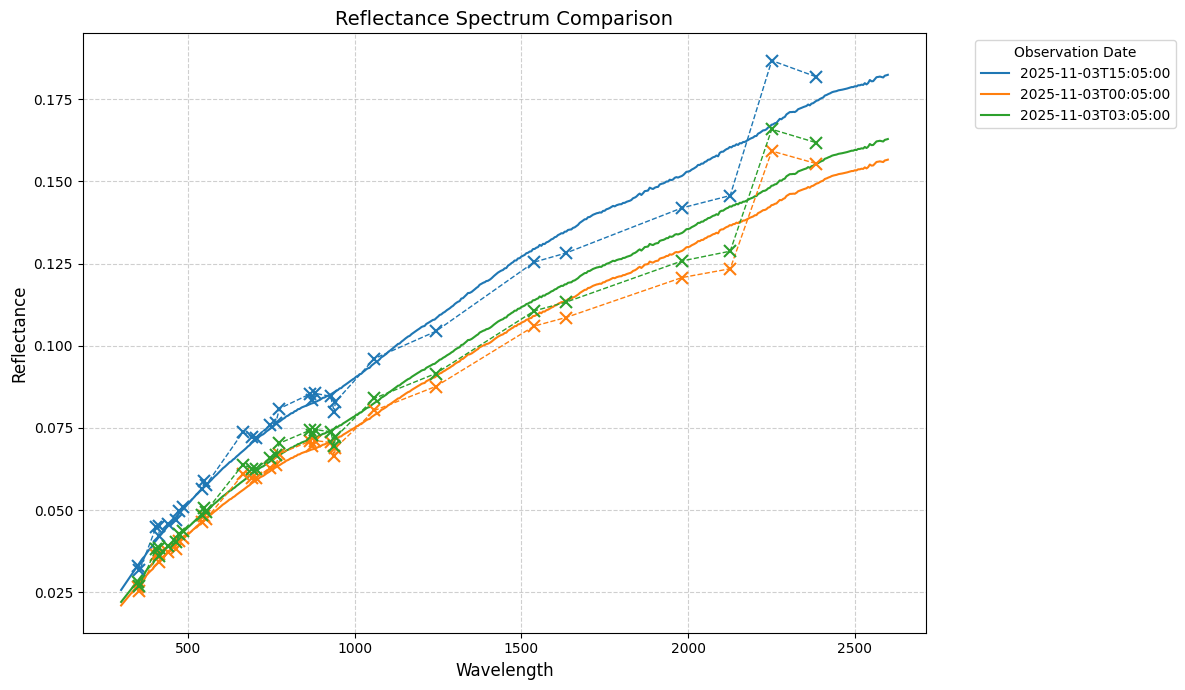

In [27]:
# 创建图形和坐标轴
plt.figure(figsize=(12, 7))
# 生成颜色循环（Matplotlib默认的10种颜色）
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 绘制每个日期的数据
for i in range(3):
    # 处理日期格式
    if isinstance(obs_date_array[i], str):
        date_label = obs_date_array[i]
    else:
        date_label = np.datetime_as_string(obs_date_array[i], unit='D')
    
    # 绘制插值后的连续曲线
    plt.plot(srf_wav, 
             fitted_reflectance_ROLO[i], 
             color=colors[i % len(colors)],
             linewidth=1.5,
             label=date_label)
    # 绘制原始数据点
    plt.plot(wavelengths,
                disk_reflectance_rolo[i],
                color=colors[i % len(colors)],
                linestyle='--',  # 虚线连接
                linewidth=1,  # 虚线宽度
                marker='x',# 十字星标记
                markersize=8,  # 标记大小
                markeredgewidth=1.5,  # 标记边缘宽度
                zorder=5)  # 确保散点在上层
# 设置坐标轴标签和标题
plt.xlabel('Wavelength', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('Reflectance Spectrum Comparison', fontsize=14)

# 设置图例
plt.legend(title='Observation Date', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left')

# 设置网格和布局
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 显示图形
plt.show()

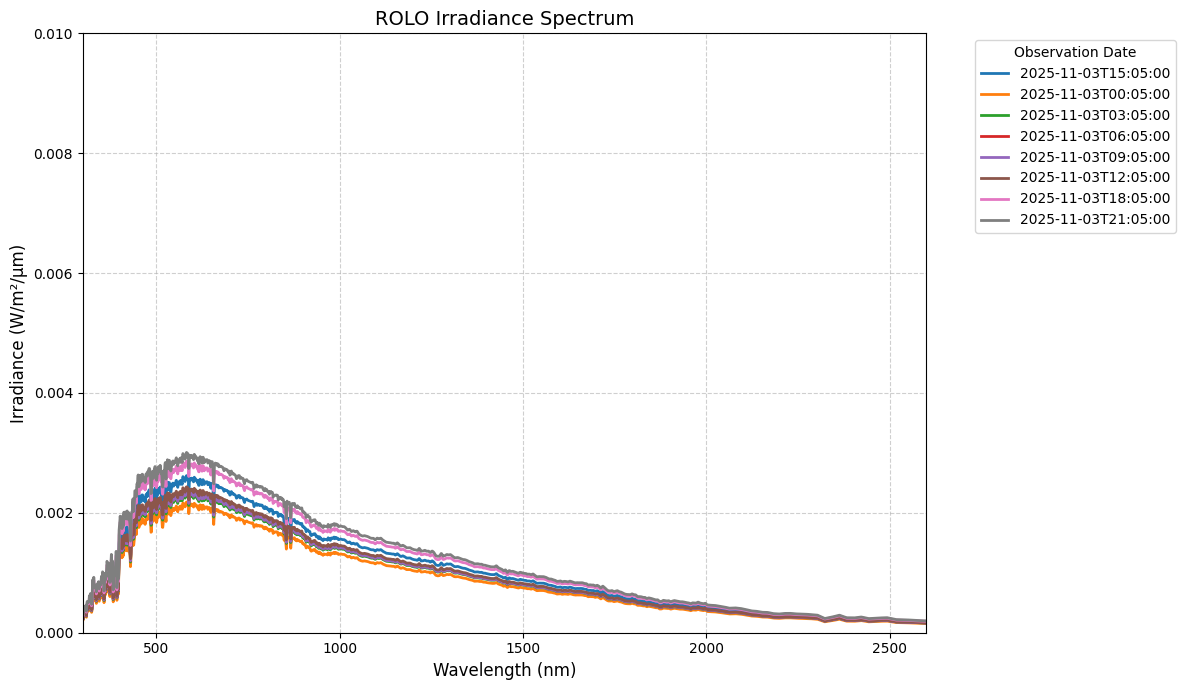

In [44]:
# 创建图形和坐标轴
fig, ax2 = plt.subplots(figsize=(12, 7))

# 绘制每个日期的辐照度曲线
for i in range(8):
    # 处理日期格式
    if isinstance(obs_dates[i], str):
        date_label = obs_dates[i]  # 取前10个字符（日期部分）
    else:
        date_label = np.datetime_as_string(obs_dates[i], unit='D')   
    # 绘制辐照度曲线
    ax2.plot(srf_wav, 
             ROLO_irradiance_spec[i], 
             '-', 
             linewidth=2, 
             color=colors[i % len(colors)],  # 使用颜色循环
             label=date_label)
# 设置坐标轴范围
ax2.set_ylim(0, 0.01)  # 根据实际数据调整
ax2.set_xlim(srf_wav.min(), srf_wav.max())  # 自动适应波长范围

# 设置坐标轴标签
ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.set_ylabel('Irradiance (W/m²/μm)', fontsize=12)

# 设置标题
ax2.set_title('ROLO Irradiance Spectrum', fontsize=14)

# 设置图例
ax2.legend(title='Observation Date', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left')

# 设置网格
ax2.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

## **参考文献**

- KIEFFER H H, STONE T C, 2005. The Spectral Irradiance of the Moon[J/OL]. The Astronomical Journal, 129(6): 2887. DOI:10.1086/430185.

- KOUYAMA T, YOKOTA Y, ISHIHARA Y, 等, 2016. Development of an application scheme for the SELENE/SP lunar reflectance model for radiometric calibration of hyperspectral and multispectral sensors[J/OL]. Planetary and Space Science, 124: 76-83. DOI:10.1016/j.pss.2016.02.003.

- KOUYAMA T, KATO S, KIKUCHI M, 等, 2019. Lunar Calibration for ASTER VNIR and TIR with Observations of the Moon in 2003 and 2017[J/OL]. Remote Sensing, 11(22): 2712. DOI:10.3390/rs11222712.


